# Analyzing StackOverflow's Developer Survey data from 2019

### Business Understanding

Coding and learning programming languages is getting more and more important as today's business world is getting more and more digitalized. Analyzing the data from StackOverflow's developer survey, I want to get a clearer picture of when today's coders got in touch with coding for the first time.
In the following I want to address four questions:

-Are there differences between continents with regard to the age of first coding experience?

-Are there differences between different age groups when it comes to their first time of coding?

-Is there a difference between gender regarding the age of 1st coding?

-Can we find evidence for a gender pay gap?

### Data Understanding

In [1]:
#Import packages
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
#Unzip the survey data
#with zipfile.ZipFile("developer_survey_2019.zip","r") as zip_ref:
#    zip_ref.extractall("developer_survey_2019.csv")

In [3]:
#Read in dataframe
df=pd.read_csv('developer_survey_2019.csv/survey_results_public.csv')

In [4]:
#Check some statistics
print(df.shape)
print(df.info())

(88883, 85)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88883 entries, 0 to 88882
Data columns (total 85 columns):
Respondent                88883 non-null int64
MainBranch                88331 non-null object
Hobbyist                  88883 non-null object
OpenSourcer               88883 non-null object
OpenSource                86842 non-null object
Employment                87181 non-null object
Country                   88751 non-null object
Student                   87014 non-null object
EdLevel                   86390 non-null object
UndergradMajor            75614 non-null object
EduOther                  84260 non-null object
OrgSize                   71791 non-null object
DevType                   81335 non-null object
YearsCode                 87938 non-null object
Age1stCode                87634 non-null object
YearsCodePro              74331 non-null object
CareerSat                 72847 non-null object
JobSat                    70988 non-null object
MgrIdiot        

In [5]:
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [6]:
#Check numeric variables
df.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


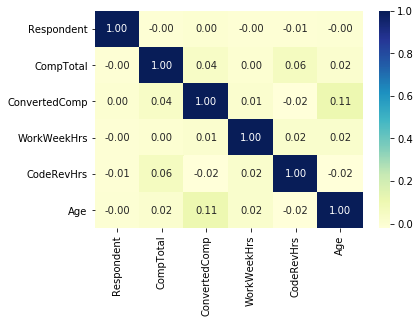

In [7]:
#correlation of numeric variables
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, fmt='.2f');

We see rather weak correlations among the numeric variables, the strongest correlation being age and converted compensation.

### Data Preparation: Part 1

In [8]:
#creating a generic function for plotting bar charts that can be re-used later on
#inspired by https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
def create_barplot(x_values, y_values, x_label, chart_title, figwidth=10, figheight=6, **kwargs):
    """ Function for creating barplots
    INPUTS:
    x_values: df column that should be displayed on x axis of the plot
    y_values: df column that should be displayed on y axis of the plot
    x_label: the label that will be displayed on the x axis
    chart_title: Title of the chart, plotted above the graph
    figwidth: width of figure, default=10
    figheight: height of figure, default=6
    **kwargs: possibility to add further variables, like y_label, if necessary > would need to be extended in the function
    currently only plotting an x-axis title
    OUTPUTS:
    barplot: the graph
    fig: the figure element
    ax: axis element, necessary for running the autolabel function
    """
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    plt.style.use('seaborn-dark')
    ax.set_xlabel(x_label, fontsize=12, fontweight='black', color = '#333F4B')
    ax.tick_params(axis='both', which='major', labelsize=12)
    barplot=ax.bar(x_values, y_values)
    ax.set_title(chart_title,fontsize=15, fontweight='black', color = '#333F4B')
    return barplot, fig, ax

In [9]:
#creating a horizontal barchart
def create_barhplot(x_values, y_values, x_label, chart_title, figsize=(10,6), **kwargs):
    """ Function for creating barplots
    INPUTS:
    x_values: df column that should be displayed on x axis of the plot
    y_values: df column that should be displayed on y axis of the plot
    x_label: the label that will be displayed on the x axis
    chart_title: Title of the chart, plotted above the graph
    figwidth: width of figure, default=10
    figheight: height of figure, default=6
    figsize: size of graph
    **kwargs: possibility to add further variables, like y_label, if necessary > would need to be extended in the function
    currently only plotting an x-axis title
    OUTPUTS:
    barplot: the graph
    fig: the figure element
    ax: axis element, necessary for running the autolabel function
    """
    fig, ax = plt.subplots(figsize=figsize)
    plt.style.use('seaborn-dark')
    ax.set_xlabel(x_label, fontsize=12, fontweight='black', color = '#333F4B')
    ax.tick_params(axis='both', which='major', labelsize=12)
    barplot=ax.barh(x_values, y_values)
    ax.set_title(chart_title,fontsize=15, fontweight='black', color = '#333F4B')
    return barplot, fig, ax

In [10]:
#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
def autolabel(continents):
    """Attach a text label above each bar in the x_values displayed in the barchart, displaying its height."""
    for continent in continents:
        height = continent.get_height()
        ax.annotate('{}'.format(round(height,2)), fontsize=12,
                    xy=(continent.get_x() + continent.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

__Variables of interest: Age1stCode, Country__: Difference of 1st age coding across countries/continents? (maybe due to different education systems)

In [11]:
#Investigated the variables we want to use
df['Age1stCode'].unique()

array(['10', '17', '22', '16', '14', '15', '11', '20', '13', '18', '12',
       '19', '21', '8', '35', '6', '9', '29', '7', '5', '23', '30', nan,
       '27', '24', 'Younger than 5 years', '33', '25', '26', '39', '36',
       '38', '28', '31', 'Older than 85', '32', '37', '50', '65', '42',
       '34', '40', '67', '43', '44', '60', '46', '45', '49', '51', '41',
       '55', '83', '48', '53', '54', '47', '56', '79', '61', '68', '77',
       '66', '52', '80', '62', '84', '57', '58', '63'], dtype=object)

We need to clean two values in order to be able to transform the variable to numeric and drop nan values. Imputation does not make much sense, as age is a factor that we cannot impute well from the dataset and would thereby also add faulty information to our analysis.
I decided to impute the value "1" for age information "Younger than 5 years" and "86" for "Older than 85" in order not to lose information about these cases.

In [12]:
#clean Age column in order to transform it to integer type
df_age=df.dropna(subset=['Age1stCode'], axis=0).copy()
index_to_change=df_age.query('Age1stCode=="Younger than 5 years"').index
df_age.at[index_to_change, 'Age1stCode']='1'
index_to_change=df_age.query('Age1stCode=="Older than 85"').index
df_age.at[index_to_change, 'Age1stCode']='86'
df_age['Age1stCode']=df_age['Age1stCode'].astype(int)

In [13]:
#Check how many respondents we have per country
df_age.groupby('Country')['Respondent'].count().sort_values(ascending=False)

Country
United States                            20735
India                                     8834
Germany                                   5801
United Kingdom                            5693
Canada                                    3351
France                                    2376
Brazil                                    1943
Poland                                    1903
Australia                                 1881
Netherlands                               1838
Russian Federation                        1672
Spain                                     1588
Italy                                     1559
Sweden                                    1264
Switzerland                                965
Israel                                     941
Turkey                                     938
Pakistan                                   910
Ukraine                                    856
Austria                                    827
Czech Republic                             755
Roman

As we have a lot of countries with very little participants, using information from these countries for a country based analysis would be dilluting, e.g. in mean values. Therefore I will only use countries with at least 15 participants in order to get relevant values when e.g. checking the mean age.

In [14]:
#limit to countries with at least 15 participants
df_age_country= pd.DataFrame(df_age['Country'].value_counts() > 15)
df_age_country=df_age_country.reset_index()
df_age_country=df_age_country.query('Country==True')

In [15]:
#get the mean age of 1st coding experience for those countries
country_list=df_age_country['index'].to_list()
df_age_filtered=df_age[df_age['Country'].isin(country_list)]
df_country=df_age_filtered.groupby('Country')['Age1stCode'].mean().sort_values()

In [16]:
len(df_country)

122

As we have 122 countries in our mean value dataset, an analyis on country basis would be really difficult to interpret and to visualize. Therefore I had the idea to merge each country with the respective continent and analyze the mean age on continent level.

In [17]:
#https://gist.github.com/pamelafox/986163
#python file with the country-continent information was found under the above link
#import a python file which has continent information for all countries in order to merge the information
from countryinfo import countries

In [18]:
#create a dataframe from the python file input
data=pd.DataFrame()
for i in countries:
    country=pd.DataFrame(i)
    data=data.append(country, ignore_index=True)

In [19]:
#clean dataframe, dropping duplicates as from merging we have lots of duplicate country rows and only need one per country
data.drop_duplicates(subset=['name'], keep='first', inplace=True)
data=data.reset_index(drop=True)

In [20]:
#merge the continent dataframe with our previous df on country information
df_withcontinent=pd.merge(df_country, data, how='left', left_on='Country', right_on='name')
#drop rows that don't have a continent information
df_withcontinent=df_withcontinent.dropna(subset=['continent'], axis=0)
print(df_withcontinent.head())

   Age1stCode            timezones code continent            name     capital
1   13.917881        Europe/Prague   CZ    Europe  Czech Republic      Prague
2   14.058932      Europe/Helsinki   FI    Europe         Finland    Helsinki
3   14.155769     Pacific/Auckland   NZ   Oceania     New Zealand  Wellington
4   14.186215        Europe/Vienna   AT    Europe         Austria      Vienna
5   14.209463  Australia/Lord_Howe   AU   Oceania       Australia    Canberra


### Data Modelling: Part 1

In [21]:
#extract information for visual analysis (mean age of 1st coding experience by continent)
continent_means=df_withcontinent.groupby('continent')['Age1stCode'].mean().sort_values(ascending=False).values
continents=df_withcontinent.groupby('continent')['Age1stCode'].mean().sort_values(ascending=False).index

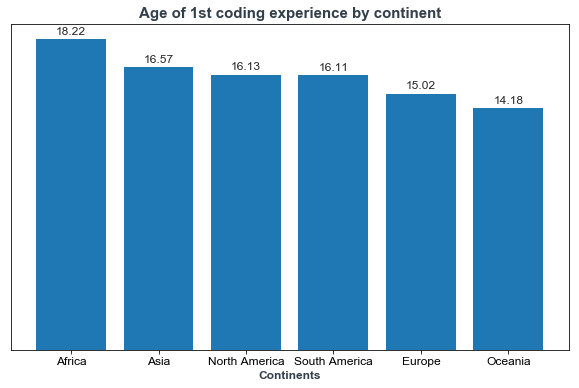

In [22]:
#bar chart for analyzing the mean age of 1st coding experience by continents
barplot, fig, ax = create_barplot(x_values=continents, y_values=continent_means, x_label='Continents', chart_title='Age of 1st coding experience by continent')

autolabel(barplot)
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.savefig('1stcoding_by_continent.png');

Clear differences in mean age of 1st coding experience by continent can be derived from the graph. African particpants were on average the oldest with a mean age of 18.22 years while Oceanian participants the youngest when getting first in touch with coding with a mean age of 14.18 years.

### Data Prepartion: Part 2

__Variables of interest: Age, Age1stCode__: Difference of 1st age coding across the different answer groups? > assumption: gets younger for younger participants (digital natives)

In [23]:
df_age['Age'].unique()

array([14. , 19. , 28. , 22. , 30. , 42. , 24. , 23. ,  nan, 21. , 31. ,
       20. , 26. , 29. , 38. , 47. , 34. , 32. , 25. , 17. , 35. , 27. ,
       44. , 43. , 62. , 37. , 45. , 18. , 33. , 36. , 16. , 39. , 64. ,
       41. , 54. , 49. , 40. , 56. , 12. , 58. , 46. , 59. , 51. , 48. ,
       57. , 52. , 50. , 23.9, 55. , 15. , 67. , 13. ,  1. , 53. , 69. ,
       65. , 17.5, 63. , 61. , 68. , 73. , 70. , 60. , 16.5, 46.5, 11. ,
       71. ,  3. , 97. , 29.5, 77. , 74. , 26.5, 26.3, 24.5, 78. , 72. ,
       66. , 76. , 10. , 75. , 99. , 83. , 79. , 36.8, 14.1, 13.5, 19.5,
       98. , 43.5, 22.5, 31.5, 21.5, 28.5, 33.6,  2. , 38.5, 30.8, 24.8,
       61.3, 81. ,  4. , 17.3, 19.9, 80. , 85. , 88. , 23.5, 16.9, 20.9,
       91. , 98.9, 57.9,  9. , 94. , 95. , 37.5, 14.5,  5. , 82. , 84. ,
       37.3, 33.5, 53.8, 31.4, 87. ])

In [24]:
df_age.query('Age <=10').head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
719,722,I am a developer by profession,No,Less than once a month but more than once per ...,The quality of OSS and closed source software ...,NaN,Afghanistan,NaN,NaN,NaN,...,Not applicable - I did not use Stack Overflow ...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Too long,Difficult
4818,4841,I am a developer by profession,Yes,Once a month or more often,The quality of OSS and closed source software ...,Employed full-time,United States,No,Some college/university study without earning ...,"A humanities discipline (ex. literature, histo...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Cour...,3.0,Man,No,NaN,NaN,Yes,Too long,Neither easy nor difficult
8802,8840,I am a student who is learning to code,Yes,Less than once a month but more than once per ...,"OSS is, on average, of LOWER quality than prop...","Not employed, and not looking for work",Canada,No,NaN,Mathematics or statistics,...,A lot less welcome now than last year,Courses on technologies you're interested in,10.0,Man,No,NaN,NaN,NaN,NaN,NaN
9613,9654,I am a developer by profession,Yes,Once a month or more often,NaN,Employed full-time,France,No,"Other doctoral degree (Ph.D, Ed.D., etc.)","Another engineering discipline (ex. civil, ele...",...,Just as welcome now as I felt last year,NaN,1.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Easy
11799,11853,I am a developer by profession,Yes,Never,The quality of OSS and closed source software ...,Employed full-time,United States,"Yes, full-time","Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,NaN,1.0,NaN,No,Straight / Heterosexual,White or of European descent,NaN,Too long,Neither easy nor difficult


As we have a lot of different age values and also floating values, I will create age buckets in decades for my analysis to make more sense of the data. Moreover, by inspecting the data of participants that stated an age of 10 or younger, I think that this data looks like incorrectly input data because most of them already have completed education, therefore I will drop this rows as the seem to be incorrect data points. As I wrote above, imputing age values is quite difficult, as it might dillute the analysis if done incorrectly.

In [25]:
#https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable
#create buckets from the age variable
df_age['Age_bucketed'] = pd.cut(df_age['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, float('Inf')], labels=['under10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70 and older'])

In [26]:
#Data of under 10 years seems unplausible > drop those rows
index_to_drop=df_age.query('Age <=10').index
df_age.drop(index_to_drop, inplace=True)

In [27]:
#overview of the buckets
df_age['Age_bucketed'].value_counts()

20-30           40419
30-40           21935
10-20            6911
40-50            6645
50-60            2206
60-70             568
70 and older      153
under10             0
Name: Age_bucketed, dtype: int64

Most participants fall in the age buckets of 20-30 and 30-40 with only very little older particpants, ie. above 60.

### Data Modelling: Part 2

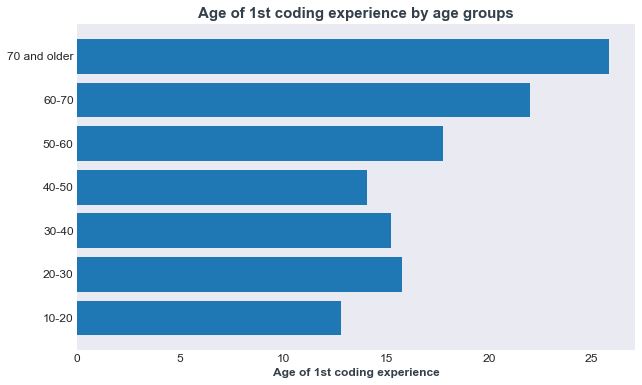

In [28]:
#plot barcharts for age groups and 1st coding experience means
age_bucketed_vals=df_age.groupby('Age_bucketed')['Age1stCode'].mean().values
age_bucketed_idx=df_age.groupby('Age_bucketed')['Age1stCode'].mean().index

barplot, fig, ax = create_barhplot(x_values=age_bucketed_idx, y_values=age_bucketed_vals, x_label='Age of 1st coding experience', chart_title='Age of 1st coding experience by age groups')
plt.savefig('age1stcoding_by_agegroups');

The older the participants are, the older they were on average when they first got in touch with coding. An exception poses the 40-50 year old bucket. A hypothesis could be the dawn of technological advances like the C64 that fell in their youth, maybe sparking interest for coding early on in their lives.

### Data Prepartion: Part 3

__Variables of interest: Age1stCode, Gender:__ Difference of gender regarding 1st coding experience?

In [29]:
df_age.Gender.value_counts()

Man                                                            77338
Woman                                                           6272
Non-binary, genderqueer, or gender non-conforming                582
Man;Non-binary, genderqueer, or gender non-conforming            178
Woman;Non-binary, genderqueer, or gender non-conforming          161
Woman;Man                                                        123
Woman;Man;Non-binary, genderqueer, or gender non-conforming       66
Name: Gender, dtype: int64

We need to clean the column to make sense of it for analyzing further. I will group all values different from "Man" and "Woman" to a bucket "Other" in order not to lose the information. Nevertheless as participants stated more than one answer in this multiple choice question, I also don't want to keep all listed options in the analysis as they will disturb a clear and concise analysis.

In [30]:
#clean up gender column by assigning non-"Man" or "Woman" values to bucket "other"
df_gender=df_age.copy()
index_other=df_gender.query('Gender not in ["Man", "Woman"]').index
df_gender.at[index_other, 'Gender']="Other"

### Data Modelling: Part 3

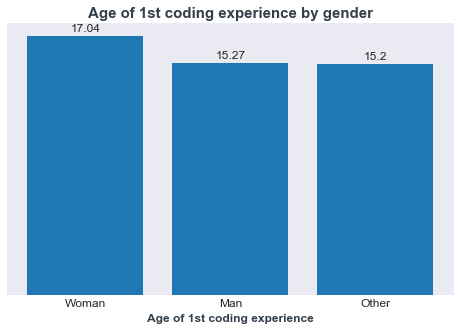

In [31]:
#plot gender vs. age of 1st coding experience
age_bucketed_vals_gend=df_gender.groupby('Gender')['Age1stCode'].mean().sort_values(ascending=False).values
age_bucketed_idx_gend=df_gender.groupby('Gender')['Age1stCode'].mean().sort_values(ascending=False).index

barplot, fig, ax = create_barplot(x_values=age_bucketed_idx_gend, y_values=age_bucketed_vals_gend, x_label='Age of 1st coding experience', chart_title='Age of 1st coding experience by gender', figwidth=8, figheight=5)
autolabel(barplot)
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.savefig('age1stcoding_by_gender');

On average the age of first coding experience for male respondents is 15.27 years and thereby nearly two years younger than the average age for female respondents (17.04 years).

__Gender__: Can we find evidence for a gender pay gap in the participants of the study?

In [32]:
#what is the share of men and women in the dataset?
count_man=df_gender.query('Gender == "Man"')['Respondent'].count()
count_woman=df_gender.query('Gender == "Woman"')['Respondent'].count()
count_other=df_gender.query('Gender == "Other"')['Respondent'].count()
share_man=count_man/df_gender.shape[0]
share_woman=count_woman/df_gender.shape[0]
share_other=count_other/df_gender.shape[0]
print("The dateset consists of " + str(round(share_man*100)) +"% male respondents.")
print("The dateset consists of " + str(round(share_woman*100)) +"% female respondents.")
print("The dateset consists of " + str(round(share_other*100)) +"% respondents that stated other options for gender.")

The dateset consists of 88.0% male respondents.
The dateset consists of 7.0% female respondents.
The dateset consists of 5.0% respondents that stated other options for gender.


__performing a t-test for checking whether salaries for men and women are alike__
H0 being that the salaries for men and women in the dataset are not different from one another, and H1 being the alternative that they are different from one another.


$$H_0: \mu_{salary_m} - \mu_{salary_f} = 0$$


$$H_0: \mu_{salary_m} - \mu_{salary_f} \neq 0$$

In [33]:
#drop rows that don't have a salary information included; as I want to investigate the salary information,
#rows with no information will be of no use for the analysis, imputing would risk a wrong outcome as salary is very individual
#and might also differ for respondents with alike characteristics, e.g. due to their negotiation successes
df_gender_filtered=df_gender.dropna(subset=['ConvertedComp'], axis=0).copy()

In [34]:
#because of the different share of men and women in the dataset, I am going to split the dataset into two separate df's
#that I am going to take seperate samples from in order to get equal sample sizes
#from every sample I am going to calculate a p-value and take the mean over these p-values in order to eliminate
#some randomness from taking a single sample
p_values = []

df_men=df_gender_filtered.query('Gender =="Man"')
df_women=df_gender_filtered.query('Gender == "Woman"')

for _ in range(10000):
    sample_men = df_men['ConvertedComp'].sample(800, replace = True)
    sample_women = df_women['ConvertedComp'].sample(800, replace = True)
    # calcuate p-value for this sample and append the info to array
    ttest,pval = ttest_ind(sample_men,sample_women)
    p_values.append(pval)

p=sum(p_values)/len(p_values)
print("p :" + str(p))

if pval <0.05:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

p :0.37732248157106174
we accept null hypothesis


### Results Evaluation

The analysis showed clear differences among the investigated groups and their mean age of first coding experience. A more detailed analysis of all results can be found in this [blogpost](https://medium.com/@jrgrec/coding-start-them-young-b83cf760e9b4).